In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sns.set()

# Data processing

In [2]:
pd.set_option("max_columns", 300)

In [3]:
train = pd.read_csv("data/raw/application_train.csv")
test = pd.read_csv("data/raw/application_test.csv")

In [4]:
fl_col = [var for var in train.columns if "FLAG" in var]

In [5]:
fl_col = [var for var in train.columns if "FLAG" in var]

train[fl_col] = train[fl_col].agg([lambda x: True if x == "Y" else False])
test[fl_col] = test[fl_col].agg([lambda x: True if x == "Y" else False])

In [6]:
train["AMT_ANNUITY"].fillna(train["AMT_INCOME_TOTAL"] * 0.2,inplace=True)
test["AMT_ANNUITY"].fillna(test["AMT_INCOME_TOTAL"] * 0.2,inplace=True)

In [7]:
train['CREDIT_SUB_GOODP'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']

In [8]:
train[['CREDIT_SUB_GOODP',"TARGET"]][train['CREDIT_SUB_GOODP'] > 0].mean()

CREDIT_SUB_GOODP    179048.076923
TARGET                   0.050000
dtype: float64

In [9]:
train['CREDIT_REL_SIZE'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_DIV_INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['PAY_YEARS'] = train['AMT_CREDIT'] / train['AMT_ANNUITY'] # pay years
train['CREDIT_SUB_GOODP'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
train['CAR_EXPENSES'] = train['FLAG_OWN_CAR'] * 5_000
train['FREE_MONEY'] = train['AMT_INCOME_TOTAL'] - train['CAR_EXPENSES'] - train['AMT_ANNUITY']

In [10]:
test['CREDIT_REL_SIZE'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_DIV_INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['PAY_YEARS'] = test['AMT_CREDIT'] / test['AMT_ANNUITY'] # pay years
test['CREDIT_SUB_GOODP'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
test['CAR_EXPENSES'] = test['FLAG_OWN_CAR'] * 5_000 
test['FREE_MONEY'] = test['AMT_INCOME_TOTAL'] - test['CAR_EXPENSES'] - test['AMT_ANNUITY']

In [11]:
car_age_median = train["OWN_CAR_AGE"].median()

train["OWN_CAR_AGE"].fillna(car_age_median, inplace=True)
test["OWN_CAR_AGE"].fillna(car_age_median, inplace=True)

ext1_median = train["EXT_SOURCE_1"].median()
ext2_median = train["EXT_SOURCE_2"].median()
ext3_median = train["EXT_SOURCE_3"].median()

train["EXT_SOURCE_1"].fillna(ext1_median, inplace=True)
train["EXT_SOURCE_2"].fillna(ext2_median, inplace=True)
train["EXT_SOURCE_3"].fillna(ext3_median, inplace=True)

test["EXT_SOURCE_1"].fillna(ext1_median, inplace=True)
test["EXT_SOURCE_2"].fillna(ext2_median, inplace=True)
test["EXT_SOURCE_3"].fillna(ext3_median, inplace=True)

In [12]:
train['CREDIT_SUB_GOODP'].fillna(train['CREDIT_SUB_GOODP'].median(), inplace=True)
test['CREDIT_SUB_GOODP'].fillna(train['CREDIT_SUB_GOODP'].median(), inplace=True)

In [13]:
def standartization(df, col, mn, st):
    df[col] = (df[col] - mn) / st
    
    return df

col_mean = train['CREDIT_REL_SIZE'].mean()
col_std = train['CREDIT_REL_SIZE'].std()
train = standartization(train, 'CREDIT_REL_SIZE', col_mean, col_std)
test = standartization(test, 'CREDIT_REL_SIZE', col_mean, col_std)

col_mean = train['ANNUITY_DIV_INCOME'].mean()
col_std = train['ANNUITY_DIV_INCOME'].std()
train = standartization(train, 'ANNUITY_DIV_INCOME', col_mean, col_std)
test = standartization(test, 'ANNUITY_DIV_INCOME', col_mean, col_std)

col_mean = train['PAY_YEARS'].mean()
col_std = train['PAY_YEARS'].std()
train = standartization(train, 'PAY_YEARS', col_mean, col_std)
test = standartization(test, 'PAY_YEARS', col_mean, col_std)

col_mean = train['FREE_MONEY'].mean()
col_std = train['FREE_MONEY'].std()
train = standartization(train, 'FREE_MONEY', col_mean, col_std)
test = standartization(test, 'FREE_MONEY', col_mean, col_std)

col_mean = train['DAYS_EMPLOYED'].mean()
col_std = train['DAYS_EMPLOYED'].std()
train = standartization(train, 'DAYS_EMPLOYED', col_mean, col_std)
test = standartization(test, 'DAYS_EMPLOYED', col_mean, col_std)

col_mean = train['DAYS_REGISTRATION'].mean()
col_std = train['DAYS_REGISTRATION'].std()
train = standartization(train, 'DAYS_REGISTRATION', col_mean, col_std)
test = standartization(test, 'DAYS_REGISTRATION', col_mean, col_std)

col_mean = train['OWN_CAR_AGE'].mean()
col_std = train['OWN_CAR_AGE'].std()
train = standartization(train, 'OWN_CAR_AGE', col_mean, col_std)
test = standartization(test, 'OWN_CAR_AGE', col_mean, col_std)


col_mean = train['CREDIT_SUB_GOODP'].mean()
col_std = train['CREDIT_SUB_GOODP'].std()
train = standartization(train, 'CREDIT_SUB_GOODP', col_mean, col_std)
test = standartization(test, 'CREDIT_SUB_GOODP', col_mean, col_std)

In [14]:
x_cols = ['CREDIT_REL_SIZE', 'ANNUITY_DIV_INCOME', 'PAY_YEARS', 'FREE_MONEY','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','CREDIT_SUB_GOODP']

# Catboost

In [20]:
from catboost import CatBoostRegressor, CatBoostClassifier, metrics
from scipy import stats
from catboost import Pool
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss

In [23]:
def crossValidation(df, x_col, y_col, cvModel, debag=False, **kwargs):
    logList = []
    aucList = []
    i = 1

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(df):
        train_part = df.loc[train_idx, :]
        val_part = df.loc[val_idx, :]

        model = cvModel(random_state=i, **kwargs)
        model.fit(X=train_part[x_col], y=train_part[y_col])
        val_pred = model.predict_proba(val_part[x_col])

        logloss_val = log_loss(val_part[y_col], val_pred)
        auc_val = roc_auc_score(val_part[y_col], val_pred[:, 1])

        logList.append(logloss_val)
        aucList.append(auc_val)

        if not debag:
            print(f'Fold: {i}, AUC: {auc_val}, LOSS: {logloss_val}')
        i += 1
    if not debag:
        print(f'AV_AUC: {np.mean(aucList)}, AV_LOGLOSS: {np.mean(logList)}')

    return np.mean(aucList)

### 0) Подбор параметров по отдельности

Первый параметр (learning_rate)

In [25]:
cvLearningRates = []

for iterated_value in [0.2, 0.4, 0.6, 0.8, 1.0]:
    cvLearningRates.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=iterated_value, depth=5, l2_leaf_reg=1))
    
    classifier = CatBoostClassifier(loss_function=metrics.Logloss(), random_state=42,
                            iterations=100, learning_rate=iterated_value, depth=5, l2_leaf_reg=1)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_lr_{iterated_value}.csv", index=False)

0:	learn: 0.5650056	total: 9.56ms	remaining: 947ms
1:	learn: 0.4793334	total: 18.4ms	remaining: 903ms
2:	learn: 0.4198207	total: 25.6ms	remaining: 829ms
3:	learn: 0.3768145	total: 32.4ms	remaining: 778ms
4:	learn: 0.3451413	total: 39ms	remaining: 741ms
5:	learn: 0.3219105	total: 45.4ms	remaining: 711ms
6:	learn: 0.3049911	total: 51.6ms	remaining: 686ms
7:	learn: 0.2921355	total: 58.9ms	remaining: 678ms
8:	learn: 0.2829205	total: 65.1ms	remaining: 658ms
9:	learn: 0.2755435	total: 72.7ms	remaining: 654ms
10:	learn: 0.2701808	total: 79.6ms	remaining: 644ms
11:	learn: 0.2659823	total: 86.7ms	remaining: 636ms
12:	learn: 0.2630665	total: 93.5ms	remaining: 626ms
13:	learn: 0.2605606	total: 101ms	remaining: 618ms
14:	learn: 0.2587833	total: 107ms	remaining: 607ms
15:	learn: 0.2574255	total: 114ms	remaining: 597ms
16:	learn: 0.2562746	total: 121ms	remaining: 589ms
17:	learn: 0.2553575	total: 127ms	remaining: 580ms
18:	learn: 0.2545838	total: 134ms	remaining: 572ms
19:	learn: 0.2540088	total: 14

Второй параметр (depth)

In [27]:
cvDepths = []
for iterated_value in [5, 6, 7, 8, 9]:
    cvDepths.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=0.2, depth=iterated_value, l2_leaf_reg=1))
    
    classifier = CatBoostClassifier(random_state=42,
                            iterations=100, learning_rate=0.2, depth=iterated_value, l2_leaf_reg=1)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_dp_{iterated_value}.csv", index=False)

0:	learn: 0.5650056	total: 7.43ms	remaining: 736ms
1:	learn: 0.4793334	total: 15.3ms	remaining: 750ms
2:	learn: 0.4198207	total: 22.1ms	remaining: 715ms
3:	learn: 0.3768145	total: 28.8ms	remaining: 691ms
4:	learn: 0.3451413	total: 35.6ms	remaining: 677ms
5:	learn: 0.3219105	total: 42.7ms	remaining: 669ms
6:	learn: 0.3049911	total: 49.4ms	remaining: 656ms
7:	learn: 0.2921355	total: 56.2ms	remaining: 647ms
8:	learn: 0.2829205	total: 63.8ms	remaining: 645ms
9:	learn: 0.2755435	total: 71ms	remaining: 639ms
10:	learn: 0.2701808	total: 78.3ms	remaining: 634ms
11:	learn: 0.2659823	total: 85.3ms	remaining: 626ms
12:	learn: 0.2630665	total: 93.1ms	remaining: 623ms
13:	learn: 0.2605606	total: 99.9ms	remaining: 614ms
14:	learn: 0.2587833	total: 108ms	remaining: 610ms
15:	learn: 0.2574255	total: 115ms	remaining: 605ms
16:	learn: 0.2562746	total: 123ms	remaining: 599ms
17:	learn: 0.2553575	total: 130ms	remaining: 590ms
18:	learn: 0.2545838	total: 136ms	remaining: 582ms
19:	learn: 0.2540088	total: 1

Третий параметр (l2-leaf-reg)

In [28]:
cvL2s = []
for iterated_value in [1, 2, 3, 4, 5]:
    cvL2s.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=0.2, depth=5, l2_leaf_reg=iterated_value))
    
    classifier = CatBoostClassifier(random_state=42,
                            iterations=100, learning_rate=0.2, depth=5, l2_leaf_reg=iterated_value)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_l2_{iterated_value}.csv", index=False)

0:	learn: 0.5650056	total: 7.79ms	remaining: 771ms
1:	learn: 0.4793334	total: 15.1ms	remaining: 740ms
2:	learn: 0.4198207	total: 22.1ms	remaining: 715ms
3:	learn: 0.3768145	total: 28.7ms	remaining: 688ms
4:	learn: 0.3451413	total: 35.3ms	remaining: 670ms
5:	learn: 0.3219105	total: 43.5ms	remaining: 682ms
6:	learn: 0.3049911	total: 50.2ms	remaining: 667ms
7:	learn: 0.2921355	total: 57.7ms	remaining: 663ms
8:	learn: 0.2829205	total: 65ms	remaining: 657ms
9:	learn: 0.2755435	total: 72.6ms	remaining: 653ms
10:	learn: 0.2701808	total: 79.8ms	remaining: 646ms
11:	learn: 0.2659823	total: 87.3ms	remaining: 640ms
12:	learn: 0.2630665	total: 94.9ms	remaining: 635ms
13:	learn: 0.2605606	total: 102ms	remaining: 630ms
14:	learn: 0.2587833	total: 110ms	remaining: 621ms
15:	learn: 0.2574255	total: 116ms	remaining: 611ms
16:	learn: 0.2562746	total: 123ms	remaining: 603ms
17:	learn: 0.2553575	total: 130ms	remaining: 593ms
18:	learn: 0.2545838	total: 138ms	remaining: 587ms
19:	learn: 0.2540088	total: 14

Submission results

In [35]:
subLearningRates = [0.75264,0.75342,0.75703,0.74988,0.74806]

In [36]:
subDepths = [0.75264,0.75554,0.75683,0.75503,0.75399]

In [37]:
subL2s = [0.75264,0.75366,0.75406,0.75248, 0.75465]

### Plotting

learning_rate:

Text(0.5, 1.0, 'Обучение рейт')

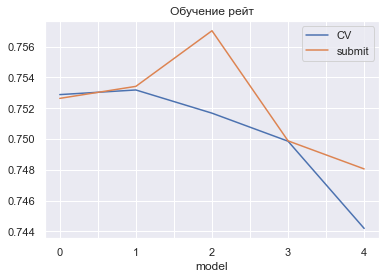

In [38]:
models = [f'{i}' for i in range(len(cvLearningRates))]

df = pd.DataFrame(list(zip(models, cvLearningRates, subLearningRates)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("Обучение рейт")

depth:

Text(0.5, 1.0, 'depths')

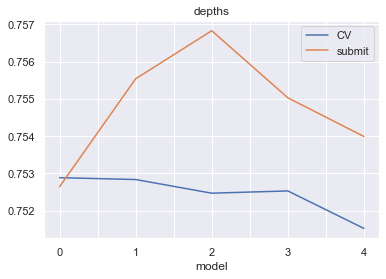

In [39]:
models = [f'{i}' for i in range(len(cvDepths))]

df = pd.DataFrame(list(zip(models, cvDepths, subDepths)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("depths")

l2 coeff:

Text(0.5, 1.0, 'l2_leaf_reg')

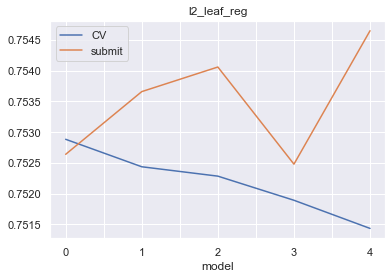

In [40]:
models = [f'{i}' for i in range(len(cvL2s))]

df = pd.DataFrame(list(zip(models, cvL2s, subL2s)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("l2_leaf_reg")

### Выводы по пункту 0

1) Переобучение имело место быть при варьировании learning_rate и depth, но оно было не очень сильным и все равно можно увидеть оптимальное значение.

2) изменение параметра l2_leaf_reg не оказывает эффекта на результат. Изменение значений метрики больше похоже на погрешность

* возможно нужно было увеличить количество значений проверяемых

### 1) GridSearchCV и RandomizedSearchCV

grid search

In [41]:
model = CatBoostClassifier(iterations=100)

In [43]:
grid = {
    'learning_rate': [0.2, 0.5, 0.7],
    'depth':[3, 6, 9],
    'l2_leaf_reg': [1, 2, 3]
}
grid_search_results = model.grid_search(grid, train[x_cols], train["TARGET"], shuffle=False, verbose=0, plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5115233	test: 0.5110253	best: 0.5110253 (0)	total: 16.8ms	remaining: 1.67s
1:	learn: 0.4088350	test: 0.4076352	best: 0.4076352 (1)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.3479285	test: 0.3461526	best: 0.3461526 (2)	total: 47.6ms	remaining: 1.54s
3:	learn: 0.3157746	test: 0.3136094	best: 0.3136094 (3)	total: 61.8ms	remaining: 1.48s
4:	learn: 0.2938240	test: 0.2914323	best: 0.2914323 (4)	total: 76.1ms	remaining: 1.45s
5:	learn: 0.2798977	test: 0.2770789	best: 0.2770789 (5)	total: 87.4ms	remaining: 1.37s
6:	learn: 0.2720372	test: 0.2691864	best: 0.2691864 (6)	total: 95.1ms	remaining: 1.26s
7:	learn: 0.2669544	test: 0.2639031	best: 0.2639031 (7)	total: 106ms	remaining: 1.22s
8:	learn: 0.2638000	test: 0.2607444	best: 0.2607444 (8)	total: 113ms	remaining: 1.14s
9:	learn: 0.2612950	test: 0.2581901	best: 0.2581901 (9)	total: 122ms	remaining: 1.1s
10:	learn: 0.2597071	test: 0.2565048	best: 0.2565048 (10)	total: 129ms	remaining: 1.05s
11:	learn: 0.2582379	test: 0.2549610	best: 0.25

In [44]:
grid_search_results['params']

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.5}

randomized search

In [45]:
model = CatBoostClassifier(iterations=100)

In [46]:
param_distribution = {
    'learning_rate': stats.uniform(0.3, 0.8),
    'depth': stats.bernoulli(p=0.2, loc=10),
    'l2_leaf_reg': stats.binom(n=2, p=0.2)
}

randomized_search_results = model.randomized_search(
    param_distribution,
    train[x_cols], train["TARGET"],
    n_iter=4,
    shuffle=False,
    search_by_train_test_split=False,
    verbose=0,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.4309810	test: 0.4312564	best: 0.4312564 (0)	total: 33.8ms	remaining: 3.35s
1:	learn: 0.3282553	test: 0.3294621	best: 0.3294621 (1)	total: 66ms	remaining: 3.23s
2:	learn: 0.2865340	test: 0.2883387	best: 0.2883387 (2)	total: 98.2ms	remaining: 3.17s
3:	learn: 0.2684897	test: 0.2708840	best: 0.2708840 (3)	total: 131ms	remaining: 3.13s
4:	learn: 0.2591219	test: 0.2620483	best: 0.2620483 (4)	total: 161ms	remaining: 3.05s
5:	learn: 0.2540140	test: 0.2572293	best: 0.2572293 (5)	total: 192ms	remaining: 3.01s
6:	learn: 0.2508248	test: 0.2550360	best: 0.2550360 (6)	total: 225ms	remaining: 2.99s
7:	learn: 0.2490738	test: 0.2537420	best: 0.2537420 (7)	total: 254ms	remaining: 2.92s
8:	learn: 0.2476671	test: 0.2528727	best: 0.2528727 (8)	total: 286ms	remaining: 2.9s
9:	learn: 0.2466660	test: 0.2523528	best: 0.2523528 (9)	total: 329ms	remaining: 2.96s
10:	learn: 0.2454348	test: 0.2518970	best: 0.2518970 (10)	total: 376ms	remaining: 3.04s
11:	learn: 0.2446509	test: 0.

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


2:	learn: 0.2482425	test: 0.2579805	best: 0.2579805 (2)	total: 166ms	remaining: 5.36s
3:	learn: 0.2458231	test: 0.2589722	best: 0.2579805 (2)	total: 222ms	remaining: 5.33s
4:	learn: 0.2426850	test: 0.2621891	best: 0.2579805 (2)	total: 286ms	remaining: 5.44s
5:	learn: 0.2399339	test: 0.2645323	best: 0.2579805 (2)	total: 345ms	remaining: 5.41s
6:	learn: 0.2381525	test: 0.2655511	best: 0.2579805 (2)	total: 405ms	remaining: 5.38s
7:	learn: 0.2366186	test: 0.2669388	best: 0.2579805 (2)	total: 469ms	remaining: 5.4s
8:	learn: 0.2339518	test: 0.2691018	best: 0.2579805 (2)	total: 543ms	remaining: 5.49s
9:	learn: 0.2315916	test: 0.2716008	best: 0.2579805 (2)	total: 614ms	remaining: 5.53s
10:	learn: 0.2290230	test: 0.2745090	best: 0.2579805 (2)	total: 679ms	remaining: 5.49s
11:	learn: 0.2280626	test: 0.2750640	best: 0.2579805 (2)	total: 739ms	remaining: 5.42s
12:	learn: 0.2263119	test: 0.2763441	best: 0.2579805 (2)	total: 801ms	remaining: 5.36s
13:	learn: 0.2242363	test: 0.2787953	best: 0.2579805

In [47]:
randomized_search_results['params']

{'depth': 10.0, 'learning_rate': 0.3013830452079781, 'l2_leaf_reg': 1.0}

### Выводы по пункту 1

1) Грид серч: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.5}

2) Рандомайзд серч: {'depth': 10.0, 'l2_leaf_reg': 1.0, 'learning_rate': 0.3013830452079781}

### 2) Feature importance

In [48]:
train_pool = Pool(train[x_cols], train["TARGET"])

In [49]:
model = CatBoostClassifier(**randomized_search_results['params'],
                iterations=1, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = x_cols

Text(0.5, 1.0, 'feature_importance')

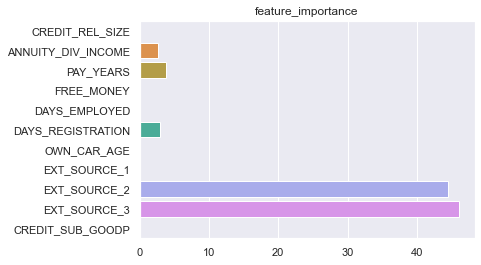

In [51]:
ax = sns.barplot(x=feature_importances, y=feature_names)
ax.set_title("feature_importance")

### Выводы по пункту 2

1) ANNUITY_DIV_INCOME, DAYS_REGISTRATION, PAY_YEARS, EXT_2, EXT_3 - в порядке возрастания значимости